In [1]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, multiply, concatenate, Activation, Masking, Reshape,RepeatVector
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout,MaxPooling1D,AveragePooling1D,Flatten,Bidirectional


import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.data_split import split_sequence_parallel

# 不加这几句，则CONV 报错
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Using TensorFlow backend.


In [2]:
data = pd.read_csv("./data/data_1009.csv", header=0,infer_datetime_format=True, engine='python')
data['Unnamed: 0']=pd.to_datetime(data['Unnamed: 0'])
data.set_index("Unnamed: 0",inplace=True)
'''
归一化
'''
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))
scaler3 = MinMaxScaler(feature_range=(0, 1))
scaler4 = MinMaxScaler(feature_range=(0, 1))
scaler5 = MinMaxScaler(feature_range=(0, 1))
scaler6 = MinMaxScaler(feature_range=(0, 1))
scaler7 = MinMaxScaler(feature_range=(0, 1))
scaler8 = MinMaxScaler(feature_range=(0, 1))
data_minmax = data.copy()
data_minmax['pm2.5']=scaler1.fit_transform(data_minmax['pm2.5'].values.reshape(-1,1))
data_minmax['DEWP']=scaler2.fit_transform(data_minmax['DEWP'].values.reshape(-1,1))
data_minmax['TEMP']=scaler3.fit_transform(data_minmax['TEMP'].values.reshape(-1,1))
data_minmax['PRES']=scaler4.fit_transform(data_minmax['PRES'].values.reshape(-1,1))
data_minmax['cbwd_NE']=scaler5.fit_transform(data_minmax['cbwd_NE'].values.reshape(-1,1))
data_minmax['cbwd_NW']=scaler6.fit_transform(data_minmax['cbwd_NW'].values.reshape(-1,1))
data_minmax['cbwd_SE']=scaler7.fit_transform(data_minmax['cbwd_SE'].values.reshape(-1,1))
data_minmax['cbwd_cv']=scaler7.fit_transform(data_minmax['cbwd_cv'].values.reshape(-1,1))

In [3]:
'''
取一年的时间，10个月做训练和验证，2个月做测试
'''
cast1 = 35064
cast2 = -1464
data_train = data_minmax[cast1:cast2]
data_test = data_minmax[cast2:] 
data_train.shape,data_test.shape

((7296, 8), (1464, 8))

In [4]:
data_train = np.array(data_train)
data_test = np.array(data_test)
data_train.shape,data_test.shape

((7296, 8), (1464, 8))

In [5]:
from utils.data_split import split_sequence_parallel

In [6]:
sw_width = 21
pred_length = 7
verbose_set = 2
X, y, features = split_sequence_parallel(data_train,sw_width,pred_length)
test_x,test_y,test_features = split_sequence_parallel(data_test,sw_width,pred_length)

In [7]:
def CNN():
    ip = Input(shape=(sw_width,features))

    y = Conv1D(128, 5, padding='same', kernel_initializer='he_uniform')(ip) 
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = MaxPooling1D(pool_size=2)(y)
    y = Flatten()(y)
    
    y = Dense(100)(y)
    y = Dropout(0.5)(y)
    out = Dense(pred_length)(y)

    model = Model(ip, out)
    model.summary()
    return model

In [8]:
CNN_model1 = CNN()
CNN_model1

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 21, 8)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 21, 128)           5248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 21, 128)           512       
_________________________________________________________________
activation_1 (Activation)    (None, 21, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1281

In [12]:
import time
from keras import backend as K
from keras.callbacks import ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
# from utils.lr_process import lr_schedule
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# lr_scheduler = LearningRateScheduler(lr_schedule)
# lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
#                                cooldown=0,
#                                patience=5,
#                                min_lr=0.5e-6)

filepath = "D:\桌面\空气质量预测综合\北京PM2.5数据集\多步预测\weights\CNN_model_weights_best.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=1)
callbacks_list = [checkpoint]

In [13]:
starttime=time.time()
CNN_model1.compile(loss=root_mean_squared_error, optimizer='adam')
history1 = CNN_model1.fit(X,y,validation_split=0.25,epochs=100, batch_size=32,callbacks=callbacks_list, verbose=2)
endtime=time.time()
dtime=endtime-starttime
print("程序运行时间为：%.8s s" % dtime)  #时间显示到微秒

Train on 5451 samples, validate on 1818 samples
Epoch 1/100
 - 4s - loss: 0.5670 - val_loss: 0.0984

Epoch 00001: val_loss improved from inf to 0.09838, saving model to D:\桌面\空气质量预测综合\北京PM2.5数据集\多步预测\weights\CNN_model_weights_best.hdf5
Epoch 2/100
 - 1s - loss: 0.2394 - val_loss: 0.0727

Epoch 00002: val_loss improved from 0.09838 to 0.07269, saving model to D:\桌面\空气质量预测综合\北京PM2.5数据集\多步预测\weights\CNN_model_weights_best.hdf5
Epoch 3/100
 - 1s - loss: 0.1208 - val_loss: 0.0669

Epoch 00003: val_loss improved from 0.07269 to 0.06693, saving model to D:\桌面\空气质量预测综合\北京PM2.5数据集\多步预测\weights\CNN_model_weights_best.hdf5
Epoch 4/100
 - 1s - loss: 0.0716 - val_loss: 0.0467

Epoch 00004: val_loss improved from 0.06693 to 0.04674, saving model to D:\桌面\空气质量预测综合\北京PM2.5数据集\多步预测\weights\CNN_model_weights_best.hdf5
Epoch 5/100
 - 1s - loss: 0.0558 - val_loss: 0.0430

Epoch 00005: val_loss improved from 0.04674 to 0.04303, saving model to D:\桌面\空气质量预测综合\北京PM2.5数据集\多步预测\weights\CNN_model_weights_best.h


Epoch 00071: val_loss did not improve from 0.03492
Epoch 72/100
 - 1s - loss: 0.0350 - val_loss: 0.0427

Epoch 00072: val_loss did not improve from 0.03492
Epoch 73/100
 - 1s - loss: 0.0350 - val_loss: 0.0425

Epoch 00073: val_loss did not improve from 0.03492
Epoch 74/100
 - 1s - loss: 0.0352 - val_loss: 0.0421

Epoch 00074: val_loss did not improve from 0.03492
Epoch 75/100
 - 1s - loss: 0.0347 - val_loss: 0.0481

Epoch 00075: val_loss did not improve from 0.03492
Epoch 76/100
 - 1s - loss: 0.0343 - val_loss: 0.0467

Epoch 00076: val_loss did not improve from 0.03492
Epoch 77/100
 - 1s - loss: 0.0346 - val_loss: 0.0458

Epoch 00077: val_loss did not improve from 0.03492
Epoch 78/100
 - 1s - loss: 0.0354 - val_loss: 0.0424

Epoch 00078: val_loss did not improve from 0.03492
Epoch 79/100
 - 1s - loss: 0.0340 - val_loss: 0.0444

Epoch 00079: val_loss did not improve from 0.03492
Epoch 80/100
 - 1s - loss: 0.0342 - val_loss: 0.0443

Epoch 00080: val_loss did not improve from 0.03492
Epo

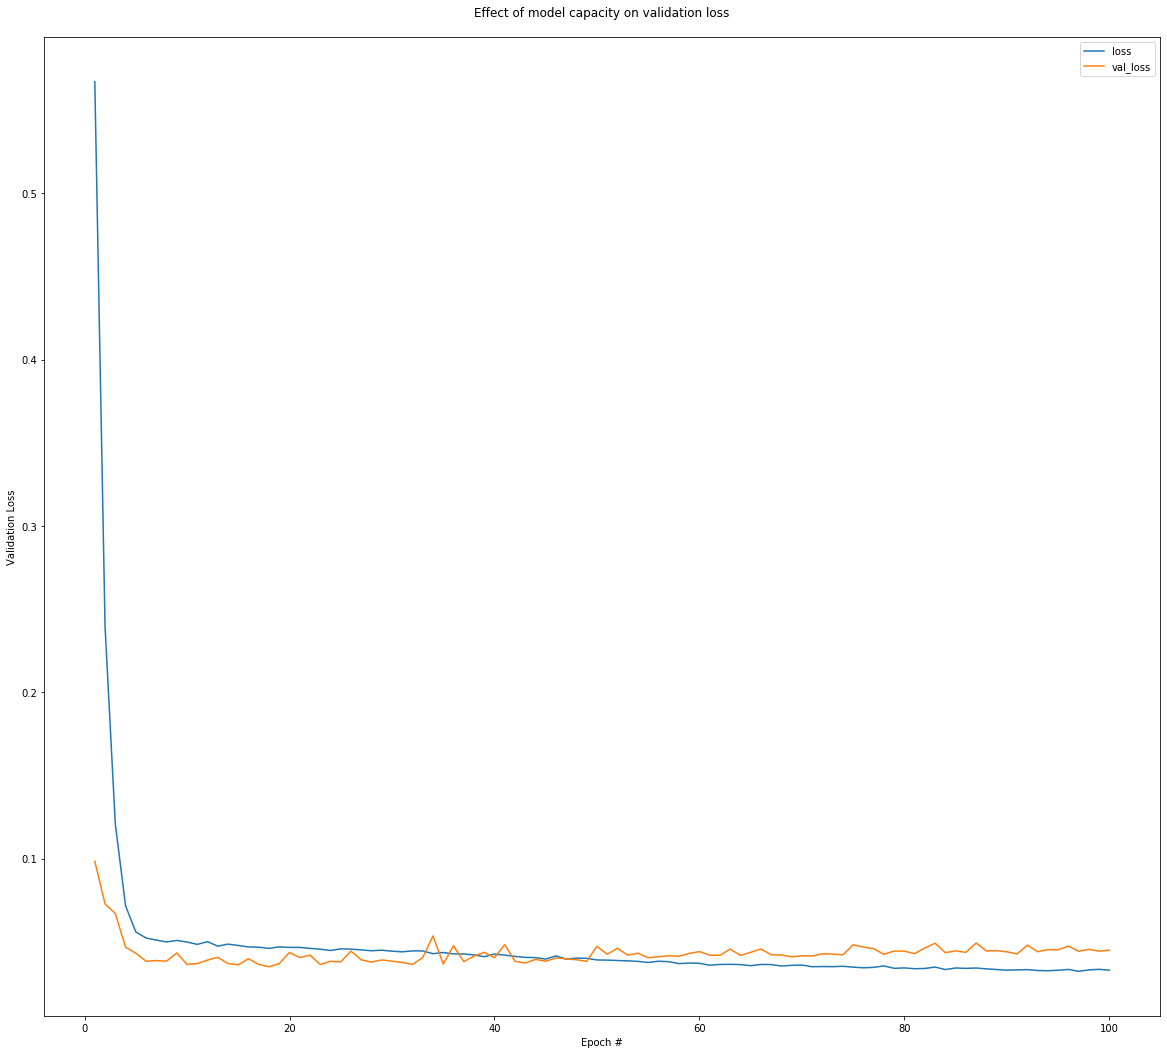

In [14]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = np.arange(100) + 1
plt.figure(figsize=(20,18))
plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title("Effect of model capacity on validation loss\n")
plt.xlabel('Epoch #')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

In [15]:
CNN_model1.load_weights(filepath)

In [16]:
predict=CNN_model1.predict(test_x)
predict=scaler1.inverse_transform(predict)

In [18]:
predict.shape

(1437, 7)

In [22]:
tf.sqrt(tf.losses.mean_squared_error(predict,scaler1.inverse_transform(test_y))).numpy().mean()

42.837668745384406

In [9]:
filepath = "D:\桌面\空气质量预测综合\北京PM2.5数据集\多步预测\weights\CNN_model_weights_best.hdf5"
CNN_model1.load_weights(filepath)

In [10]:
predict=CNN_model1.predict(test_x)
predict=scaler1.inverse_transform(predict)

In [11]:
tf.sqrt(tf.losses.mean_squared_error(predict,scaler1.inverse_transform(test_y))).numpy().mean()

42.837668745384406

In [12]:
tf.sqrt(tf.losses.mae(predict,scaler1.inverse_transform(test_y))).numpy().mean()

5.666050527648841

In [13]:
for i in range(7):
    loss1 = tf.sqrt(tf.losses.mean_squared_error(predict[:,i],scaler1.inverse_transform(test_y)[:,i])).numpy()
    print(i,":",loss1)

0 : 30.15510659585976
1 : 41.49136384162472
2 : 50.68777356358003
3 : 58.65727430497277
4 : 65.118334109958
5 : 70.50776229689372
6 : 75.23266100663524


In [15]:
for i in range(7):
    loss1 = tf.sqrt(tf.losses.mae(predict[:,i],scaler1.inverse_transform(test_y)[:,i])).numpy()
    print(i,":",loss1)

0 : 4.5598241776645745
1 : 5.2045598561200395
2 : 5.710959346193922
3 : 6.303268515994264
4 : 6.667750891755016
5 : 6.952872639688213
6 : 7.286439525129239
